
<div align="center">
  <a href="https://www.w-hs.de/maschinenbau-master-boh/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png" 
    alt="Images" width="500" height="200">
  </a>
</div>
<br>
<h1 align="center"> Sondergebiete der Simulation</h1>
<h3 align="center"> WS 21/22 </h3>
<br>

### 1. Kurze  Herleitung der Bewegungsgleichungen
### 2. Numerische Lösung der Differentialgleichungen
### 3. Lösungsfunktion interpolieren
### 4. Trainingspunkte extrahieren
### 5. PINN trainieren
### 6. Ergebnisse darstellen
<br>

### Credits:

* [benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)

In [1]:
import sympy
from sympy import symbols, Function, diff, sin, cos, Matrix, Rational, Eq, solve, lambdify
import sympy.physics.mechanics as mech
mech.init_vprinting()

### Herleitung der Bewegungsgleichungen 

Ausführliche Beschreibung der Herleitung:
[Inverted Pendulum Legrange](https://github.com/lennart2810/InvertedPendulumSDS/blob/master/MKS/Inverted%20Pendulum%20Legrange.ipynb) 

In [2]:
# symbolischen Variablen anlegen
t, l, M, m, g = symbols('t l M m g')

# Zwangsbedingung
y = 0

# generalisierte Koordinaten und deren Ableitungen:
x = Function('x')(t)
x_d = diff(x,t)
x_dd = diff(x_d,t)

theta = Function('theta')(t)
theta_d = diff(theta,t)
theta_dd = diff(theta,t,t)

# Kinematik
x2, y2 = x - l * sin(theta), y + l * cos(theta)
x2_d, y2_d = x2.diff(t), y2.diff(t)

# Legrange-Funktion
T = Rational(1,2) * M * (x_d)**2 + Rational(1,2) * m * (x2_d**2 + y2_d**2)
V = M * g * y + m * g * y2 
L = T - V

# Euler-Legrange
LE_x = diff(diff(L, x_d), t) - diff(L, x)
LE_theta = diff(diff(L, theta_d), t) - diff(L, theta)

# Nach x_dd und theta_dd umstellen
solutions = solve([LE_x, LE_theta], (x_dd, theta_dd), simplify=True) 
sol_x_dd = Eq(x_dd-solutions[x_dd], 0)
sol_theta_dd = Eq(theta_dd - solutions[theta_dd], 0)
display(Matrix([sol_x_dd, sol_theta_dd]))

⎡       ⎛              2⎞                  ⎤
⎢     m⋅⎝g⋅cos(θ) - l⋅θ̇ ⎠⋅sin(θ)           ⎥
⎢   - ────────────────────────── + ẍ = 0   ⎥
⎢                    2                     ⎥
⎢           M + m⋅sin (θ)                  ⎥
⎢                                          ⎥
⎢    ⎛                        2⎞           ⎥
⎢    ⎝M⋅g + g⋅m - l⋅m⋅cos(θ)⋅θ̇ ⎠⋅sin(θ)    ⎥
⎢θ̈ - ────────────────────────────────── = 0⎥
⎢              ⎛         2   ⎞             ⎥
⎣            l⋅⎝M + m⋅sin (θ)⎠             ⎦

### Umwandlung des symbolischen Gleichungssystems in numerische Funtkionen mit  `sympy.lambdify`

In [3]:
dxdt = lambdify(x_d, x_d)
dvdt = lambdify((t,g,M,m,l,theta,theta_d), solutions[x_dd])

dthetadt = lambdify(theta_d, theta_d)
domegadt = lambdify((t,g,M,m,l,theta,theta_d), solutions[theta_dd])

def dSdt(S, t, g, M, m, l):
    x, v, theta, omega = S
    return [
        dxdt(v),
        dvdt(t,g,M,m,l,theta, omega),
        dthetadt(omega),
        domegadt(t,g,M,m,l,theta,omega)
    ]

time.shape: (34,) <class 'numpy.ndarray'>
x.shape: (34,)
theta.shape: (34,)
data.shape: (34, 2)


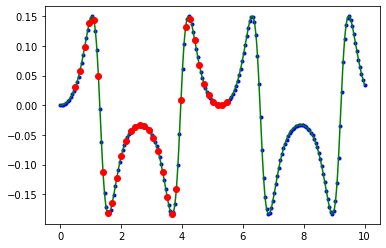

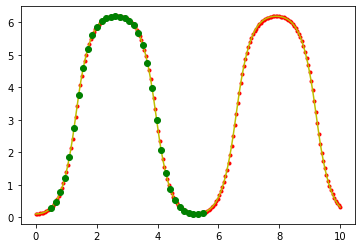

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

t1 = 10                          # s 
samples = 200                    # n 
t = np.linspace(0, t1, samples)     # s

g = 9.81                         # m/s^2
M = 5                            # kg
m = 1                            # kg
l = 1                            # m
F = 0                            # N

S0 = [0, 0, 0.1, 0]              # m, m/s, rad, rad/s

# numerische Lösung
ans = odeint(dSdt, y0=S0, t=t, args=(g, M, m, l))
x = ans.T[0]
theta = ans.T[2]

# numerische Lösung --> Lösungsfunktion interpolieren
# wird ausschließlich für DeepXDE benötigt (solution=func)
t_new = np.linspace(0, t1, samples+2000)    
x_f = interpolate.interp1d(t, x, 'cubic')
theta_f = interpolate.interp1d(t, theta, 'cubic')

# 'Messwerte'
a, b, i = 10, 110, 3 # jeden i. Punkt im Intervall [a,b] 
t_data = t[a:b:i]
x_data = x[a:b:i]
theta_data = theta[a:b:i]

# Data für NN zusammenfassen:
data = np.concatenate((x_data, theta_data)).reshape(2, len(t_data)).T
print('time.shape:', t_data.shape, type(t_data))
print('x.shape:', x_data.shape)
print('theta.shape:', theta_data.shape)
print('data.shape:', data.shape)


# Visualisierung 
plt.plot(t, x, 'b.')
plt.plot(t_new, x_f(t_new), 'g-')
plt.plot(t_data, data[:,0], 'ro') # data[:,1] --> x_data
plt.show()

plt.plot(t, theta, 'r.')
plt.plot(t_new, theta_f(t_new), 'y-')
plt.plot(t_data, data[:,1], 'go') # data[:,1] --> theta_data
plt.show()

### *Messpunkte* mit NN annähern

(200, 2)


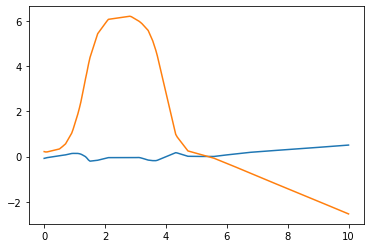

In [10]:
import tensorflow as tf
from tensorflow import keras

def my_mse(y_true, y_pred):
    mse = tf.reduce_mean((y_pred-y_true)**2)
    return mse

def create_model_nn():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 2, activation = 'linear'))
    model.compile(loss=my_mse, optimizer="adam") # same as 'mse'
    return model


epochs = 10000
model = create_model_nn()
model.fit(t_data, data, epochs=epochs, verbose=0)
prediction = model.predict(t)
x_p = prediction[:,0]
theta_p = prediction[:,1]
print(prediction.shape)
plt.plot(t, x_p, t, theta_p)
plt.show()

In [11]:
display(Matrix([sol_x_dd, sol_theta_dd]))

⎡       ⎛              2⎞                  ⎤
⎢     m⋅⎝g⋅cos(θ) - l⋅θ̇ ⎠⋅sin(θ)           ⎥
⎢   - ────────────────────────── + ẍ = 0   ⎥
⎢                    2                     ⎥
⎢           M + m⋅sin (θ)                  ⎥
⎢                                          ⎥
⎢    ⎛                        2⎞           ⎥
⎢    ⎝M⋅g + g⋅m - l⋅m⋅cos(θ)⋅θ̇ ⎠⋅sin(θ)    ⎥
⎢θ̈ - ────────────────────────────────── = 0⎥
⎢              ⎛         2   ⎞             ⎥
⎣            l⋅⎝M + m⋅sin (θ)⎠             ⎦

In [29]:
lr = 0.001
import torch 
import deepxde as dde

def my_new_physics(y_true, y_pred):
    
    x_true = y_true[0]
    theta_true = y_true[1]
    x_pred = y_pred[0]
    theta_pred = y_pred[1]
    
    # normaler Loss
    loss_x = tf.reduce_mean((x_pred-x_true)**2)
    loss_theta = tf.reduce_mean((theta_pred-theta_true)**2)
    
    print(y_true.shape)
    
    # Gradienten von x und theta nach t_data
    #x_pred_d = dde.grad.jacobian(1, 1)
    #x_pred_dd = dde.grad.hessian(x_pred, t_data)
    
    #x_pred_d = tf.gradients(x_pred, t_data)
    #x_pred_d = torch.autograd.grad(x_pred, t_data)
    #x_pred_dd = tf.gradients(x_pred_d, t_data)
    #x_pred_dd = tf.hessians(x_pred_test, t_data_test)
    #theta_pred_d = tf.gradients(theta_pred, t_data)
    #theta_pred_dd = tf.hessians(theta_pred, t_data)
    
    # Physics Loss
    #physics_loss_x = x_pred_dd-(m*tf.sin(theta_pred)*(g*tf.cos(theta_pred)-l*theta_pred_d**2))/(M+m*tf.sin(theta_pred)**2)
    #physics_loss_theta = DGL theta_dd nach 0 umstellen
    
    #physics_loss_x = lr * tf.reduce_mean(physics_loss_x**2)
    #physics_loss_x = lr * tf.reduce_mean(physics_loss_theta**2)

    physics_loss_x = 0
    physics_loss_theta = 0
    
    return loss_x + loss_theta + physics_loss_x + physics_loss_theta



def create_model_pinn():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 2, activation = 'linear'))
    model.compile(loss=my_new_physics, optimizer="adam") # same as 'mse'
    return model

In [30]:
epochs = 10000
model = create_model_pinn()
model.fit(t_data, data, epochs=epochs, verbose=0)
prediction = model.predict(t)
x_p = prediction[:,0]
theta_p = prediction[:,1]
print(prediction.shape)
plt.plot(t, x_p, t, theta_p)
plt.show()

(?, ?)


OperatorNotAllowedInGraphError: in user code:

    <ipython-input-29-12581dff89d4>:23 my_new_physics  *
        x_pred_d = torch.autograd.grad(x_pred, t_data)
    /Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:207 grad  *
        outputs = (outputs,) if isinstance(outputs, torch.Tensor) else tuple(outputs)
    /Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:503 __iter__  **
        self._disallow_iteration()
    /Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:499 _disallow_iteration
        self._disallow_in_graph_mode("iterating over `tf.Tensor`")
    /Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:477 _disallow_in_graph_mode
        raise errors.OperatorNotAllowedInGraphError(

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


In [25]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

num_samples = 1024
x_train = 4 * (tf.random.uniform((num_samples, )) - 0.5)
y_train = tf.zeros((num_samples, ))
inputs = Input(shape=(1,))
x = Dense(16, 'tanh')(inputs)
x = Dense(8, 'tanh')(x)
x = Dense(4)(x)
y = Dense(1)(x)
model = Model(inputs=inputs, outputs=y)

# using the high level tf.data API for data handling
x_train = tf.reshape(x_train,(-1,1))
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(1)

opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)


@tf.function
def test():
    for step, (x,y_true) in enumerate(dataset):
        # we need to convert x to a variable if we want the tape to be 
        # able to compute the gradient according to x
        x_variable = tf.Variable(x) 
        with tf.GradientTape() as model_tape:
            with tf.GradientTape() as loss_tape:
                loss_tape.watch(x_variable)
                y_pred = model(x_variable)
            dy_dx = loss_tape.gradient(y_pred, x_variable)
            loss = tf.math.reduce_mean(tf.square(dy_dx + 3 * y_pred - y_true))
        grad = model_tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        if step%20==0:
            print(f"Step {step}: loss={loss.numpy()}")
            
test()

RuntimeError: Attempting to capture an EagerTensor without building a function.

In [ ]:
# dautet viel zu lange

#from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter

episodes = 10000
model = create_model()

fig = plt.figure(figsize=(10,4))
ax = plt.axes(xlim=(-1, t1+5), ylim=(-1, 6.5), autoscale_on=False) 
ax.plot(t, x, color='lightgrey', marker='', lw=1, alpha=0.8, label='numerical solutions') # true x
ax.plot(t, theta, color='lightgrey', marker='', lw=1, alpha=0.8) # true theta
ax.plot(t_data, data[:,0], color="tab:purple", marker='.', lw=0, markersize=5, alpha=0.5, label='training $x$') # training x
ax.plot(t_data, data[:,1] , color="royalblue", marker='.', lw=0, markersize=5, alpha=0.5, label=r'training $\theta$') # training theta


line0, = ax.plot([], [], lw=1, color="tab:purple", label='prediction $x$') # predictio x 
line1, = ax.plot([], [], lw=1, color="royalblue", label=r'prediction $\theta$') # prediction theta
ax.axis("off")
ax.legend(loc=(0.7,0.45), frameon=False, fontsize=10)

# Zeitlabel
episode_template = 'episode: %.0f'
episode_template_text = ax.text(0.7,0.95, '', fontsize=18, transform=ax.transAxes)

def animate(i):

    model.fit(t_data, data, epochs=1, verbose=0)
    prediction = model.predict(t)

    line0.set_data(t, prediction[:,0]) # x
    line1.set_data(t, prediction[:,1]) # theta
    episode_template_text.set_text(episode_template % (i))
        
    return line0, line1, episode_template_text

#anim = animation.FuncAnimation(fig, animate, frames=episodes, blit=True)
#anim.save("InvertedPendulum_NN.gif", writer='pillow', fps=episodes/10, dpi=200)